# Complex Word Identification (CWI) - LSTM based RNN Model

=========== Project Code for CMT 318 Portfolio Assessment ==========

Module : Computational Linguistics

Code: 318

Name: Shreyas Ramachandran

Student ID: 24001871

==============================================================

This notebook features the performance analysis LSTM based RNN model on a critical sub-task of Lexical Simplification - Complex Word Identification

All experiments have been conducted on colab to leverage powerful GPUs for faster training and evaluation.

## 1. Complexity Prediction
For complexity prediction, we use the CompLex dataset to train a LSTM based RNN network to predict the complexity of a target word. The predictor's performance is evaluated to compare the accuracy and pearson's corelation of the predicted complexity.

We also demonstrate the models' complexity prediction of example inputs

IMPORTANT: All datasets and resources required for this code are provided in the zip file, under the datasets directory. Please refer readme file for further instructions on using the dataset files

### 1. Install Dependencies

In [2]:
# Install dependencies for Colab environment
!pip install torch==2.0.1 pandas==2.0.3 numpy==1.24.3 scikit-learn==1.3.0 torchtext==0.15.2 nltk==3.8.1 matplotlib==3.7.2 scipy==1.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/84

The training code has been commented out. Uncomment and exectue this cell to train the model. If you dont want to run the training code, then you can download the trained model from the below Drive link and upload it into the session storage (update the correct path in below cell)

- CWI LSTM Model: https://drive.google.com/file/d/1SUgTEqCPIpfmjpVFsVYMiggGQ7jCHohz/view?usp=sharing

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Loading GloVe embeddings...

Test Set Evaluation:
Test Loss: 0.0169
Test MSE: 0.0169
Test R2: 0.2414
Test Accuracy (within ±0.1): 57.05%
Pearson Correlation: 0.5205
Spearman Correlation: 0.4903

Generating plot of predicted vs true complexity...


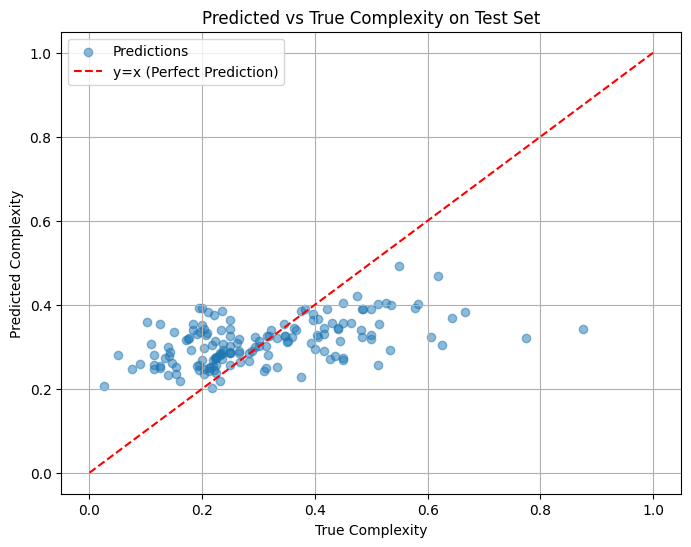

Plot saved as 'pred_vs_true_complexity.png'

Example Predictions:
Sentence: Don't curse the king, no, not in your thoughts; and don't curse the rich in your bedroom: for a bird of the sky may carry your voice, and that which has wings may tell the matter.
Target: wings
True Complexity: 0.1528
Predicted Complexity: 0.2349
--------------------------------------------------
Sentence: a time to tear, and a time to sew; a time to keep silence, and a time to speak;
Target: silence
True Complexity: 0.3167
Predicted Complexity: 0.2812
--------------------------------------------------
Sentence: However, we were unable to consistently turn off the human E2 expression cassette by the potent tetracycline analogue, doxycycline in either of the two transgenic lines tested (data not shown).
Target: analogue
True Complexity: 0.4219
Predicted Complexity: 0.3904
--------------------------------------------------
Sentence: In those days saw I in Judah some men treading winepresses on the Sabbath, and br

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import nltk
from nltk.tokenize import word_tokenize
from torchtext.vocab import GloVe
import matplotlib.pyplot as plt
import os

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Section 2: Load GloVe embeddings
print("Loading GloVe embeddings...")
glove = GloVe(name='6B', dim=100)  # 100-dimensional GloVe embeddings
embedding_dim = 100

# Section 3: Dataset loading function
def load_dataset(file_path):
    """
    Load and clean the dataset from the given file path.

    Parameters:
    file_path (str): Path to the dataset file.

    Returns:
    pd.DataFrame: Cleaned dataset.
    """
    df = pd.read_csv(file_path, sep='\t', usecols=['sentence', 'token', 'complexity'])
    # Remove the row containing headings if it exists
    if df.iloc[0]['sentence'] == 'sentence':
        df = df.iloc[1:]
    return df

# Define file paths (Update with actual file paths)
train_path = "/content/lcp_single_train.tsv"
trial_path = "/content/lcp_single_trial.tsv"

# Load datasets
complex_train_df = load_dataset(train_path)
complex_trial_df = load_dataset(trial_path)

# Section 4: Custom Dataset for CompLex
class LSTMCompLexDataset(Dataset):
    def __init__(self, dataframe, max_length=128):
        self.data = dataframe
        self.max_length = max_length
        self.vocab = glove.stoi  # String-to-index mapping for GloVe
        self.vectors = glove.vectors  # Pre-trained embedding vectors
        self.default_vector = torch.zeros(embedding_dim)  # Default for OOV tokens

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = str(self.data.iloc[idx]['sentence'])
        target = str(self.data.iloc[idx]['token']).lower()
        complexity = float(self.data.iloc[idx]['complexity'])

        # Tokenize sentence
        tokens = word_tokenize(sentence.lower())

        # Find target word index
        target_idx = tokens.index(target) if target in tokens else len(tokens) // 2

        # Create context window around target (padding if necessary)
        half_window = self.max_length // 2
        start_idx = max(0, target_idx - half_window)
        end_idx = min(len(tokens), target_idx + half_window + 1)
        context_tokens = tokens[start_idx:end_idx]

        # Convert tokens to GloVe embeddings
        embeddings = []
        for token in context_tokens:
            if token in self.vocab:
                emb = self.vectors[self.vocab[token]]
            else:
                emb = self.default_vector
            embeddings.append(emb)

        # Pad or truncate to max_length
        while len(embeddings) < self.max_length:
            embeddings.append(self.default_vector)
        embeddings = embeddings[:self.max_length]

        embeddings = torch.stack(embeddings)  # Convert list of tensors to tensor
        complexity = torch.tensor(complexity, dtype=torch.float32)

        return embeddings, complexity

# Section 5: LSTM Model Definition
class LSTMComplexityModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, dropout=0.3):
        super(LSTMComplexityModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [batch_size, seq_length, embedding_dim]
        lstm_out, (hidden, cell) = self.lstm(x)
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden = self.dropout(hidden)
        out = self.fc(hidden)
        return out.squeeze(-1)

# Section 6: Training Function
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, save_path='lstm_complexity_model.pt'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for embeddings, complexity in train_loader:
            embeddings, complexity = embeddings.to(device), complexity.to(device)

            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, complexity)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * embeddings.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_true = [], []
        with torch.no_grad():
            for embeddings, complexity in val_loader:
                embeddings, complexity = embeddings.to(device), complexity.to(device)
                outputs = model(embeddings)
                loss = criterion(outputs, complexity)
                val_loss += loss.item() * embeddings.size(0)

                val_preds.extend(outputs.cpu().numpy())
                val_true.extend(complexity.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_mse = mean_squared_error(val_true, val_preds)
        val_r2 = r2_score(val_true, val_preds)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val MSE: {val_mse:.4f}, Val R2: {val_r2:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model with Val Loss: {val_loss:.4f}")

# Section 7: Evaluation Function with Correlations
def evaluate_model(model, test_loader, tolerance=0.1):
    model.eval()
    preds, true = [], []
    criterion = nn.MSELoss()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for embeddings, complexity in test_loader:
            embeddings, complexity = embeddings.to(device), complexity.to(device)
            outputs = model(embeddings)
            loss = criterion(outputs, complexity)
            test_loss += loss.item() * embeddings.size(0)

            # Collect predictions and true values
            preds.extend(outputs.cpu().numpy())
            true.extend(complexity.cpu().numpy())

            # Calculate accuracy (within tolerance)
            for pred, actual in zip(outputs.cpu().numpy(), complexity.cpu().numpy()):
                if abs(pred - actual) <= tolerance:
                    correct += 1
                total += 1

    test_loss /= len(test_loader.dataset)
    mse = mean_squared_error(true, preds)
    r2 = r2_score(true, preds)
    accuracy = (correct / total) * 100 if total > 0 else 0

    # Calculate Pearson and Spearman correlations
    pearson_corr, _ = pearsonr(true, preds)
    spearman_corr, _ = spearmanr(true, preds)

    print("\nTest Set Evaluation:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R2: {r2:.4f}")
    print(f"Test Accuracy (within ±{tolerance}): {accuracy:.2f}%")
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    print(f"Spearman Correlation: {spearman_corr:.4f}")

    return mse, r2, accuracy, pearson_corr, spearman_corr, preds, true

# Section 8: Plotting Function
def plot_pred_vs_true(preds, true):
    plt.figure(figsize=(8, 6))
    plt.scatter(true, preds, alpha=0.5, label='Predictions')
    plt.plot([0, 1], [0, 1], 'r--', label='y=x (Perfect Prediction)')
    plt.xlabel('True Complexity')
    plt.ylabel('Predicted Complexity')
    plt.title('Predicted vs True Complexity on Test Set')
    plt.legend()
    plt.grid(True)
    plt.savefig('pred_vs_true_complexity.png')
    plt.show()
    plt.close()


def predict_complexity(sentence, target_word):
    """
    Predicts the complexity of a target word in a given sentence using the trained LSTM model.

    Args:
        sentence (str): The input sentence.
        target_word (str): The target word whose complexity needs to be predicted.

    Returns:
        float: The predicted complexity score.
    """

    # Load the trained model (replace with your model's path)
    model = LSTMComplexityModel(embedding_dim=100, hidden_dim=128, num_layers=2, dropout=0.3).to(device)
    model.load_state_dict(torch.load('/content/lstm_complexity_model.pt'))
    model.eval()

    # Create a dummy DataFrame for the input
    data = {'sentence': [sentence], 'token': [target_word], 'complexity': [0]}  # Complexity is a placeholder
    df = pd.DataFrame(data)

    # Create a dataset and dataloader for the input sentence
    dataset = LSTMCompLexDataset(df)
    dataloader = DataLoader(dataset, batch_size=1)

    with torch.no_grad():
        for embeddings, _ in dataloader:
            embeddings = embeddings.to(device)
            predicted_complexity = model(embeddings).item()
            return predicted_complexity


# Section 10: Main Execution
def main():
    # Split trial data for validation and testing
    train_df = complex_train_df
    val_df, test_df = train_test_split(complex_trial_df, test_size=0.5, random_state=42)

    # Create datasets
    train_dataset = LSTMCompLexDataset(train_df)
    val_dataset = LSTMCompLexDataset(val_df)
    test_dataset = LSTMCompLexDataset(test_df)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model
    model = LSTMComplexityModel(
        embedding_dim=100,
        hidden_dim=128,
        num_layers=2,
        dropout=0.3
    ).to(device)

    """ Uncomment to train
    # Train model
    print("Training LSTM model...")
    train_model(
        model,
        train_loader,
        val_loader,
        epochs=10,
        lr=0.001,
        save_path='/content/lstm_complexity_model.pt'
    )
    """

    # Load best model and evaluate (Update with actual path)
    model.load_state_dict(torch.load('/content/lstm_complexity_model.pt'))
    mse, r2, accuracy, pearson_corr, spearman_corr, preds, true = evaluate_model(model, test_loader, tolerance=0.1)

    # Plot predicted vs true complexity
    print("\nGenerating plot of predicted vs true complexity...")
    plot_pred_vs_true(preds, true)
    print("Plot saved as 'pred_vs_true_complexity.png'")

    # Example predictions
    print("\nExample Predictions:")
    model.eval()
    with torch.no_grad():
        sample_df = test_df.sample(n=5, random_state=42)
        sample_dataset = LSTMCompLexDataset(sample_df)
        sample_loader = DataLoader(sample_dataset, batch_size=1)

        for i, (embeddings, complexity) in enumerate(sample_loader):
            embeddings, complexity = embeddings.to(device), complexity.to(device)
            pred = model(embeddings)
            sentence = sample_df.iloc[i]['sentence']
            token = sample_df.iloc[i]['token']
            true_complexity = complexity.item()
            pred_complexity = pred.item()
            print(f"Sentence: {sentence}")
            print(f"Target: {token}")
            print(f"True Complexity: {true_complexity:.4f}")
            print(f"Predicted Complexity: {pred_complexity:.4f}")
            print("-" * 50)

    # LSTM Complexity Prediction Example
    print("\nLSTM Complexity Prediction Example")
    sentence = "Lebanon is sharply split along sectarian lines, with 18 religious sects."
    target_word = "sectarian"
    predicted_complexity = predict_complexity(sentence, target_word)
    print(f"Predicted complexity of '{target_word}' in '{sentence}': {predicted_complexity:.4f}")

if __name__ == "__main__":
    main()

In [4]:
#LSTM Complexity Prediction Example
print("LSTM Complexity Prediction Example")
sentence = "but he whose genealogy is not counted from them has accepted tithes from Abraham, and has blessed him who has the promises."
target_word = "genealogy"
predicted_complexity = predict_complexity(sentence, target_word)
print(f"Predicted complexity of '{target_word}' in '{sentence}': {predicted_complexity:.4f}")

LSTM Complexity Prediction Example
Predicted complexity of 'sectarian' in 'Lebanon is sharply split along sectarian lines, with 18 religious sects.': 0.3488
